In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
# kaggle competition: https://www.kaggle.com/competitions/what-on-the-video
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

samyanis_videos_path = kagglehub.dataset_download('your_account/videos')

print('Data source import complete.')


100%|██████████| 677M/677M [00:11<00:00, 63.1MB/s]

Extracting files...


Data source import complete.


In [ ]:
print(samyanis_videos_path)

/root/.cache/kagglehub/datasets/samyanis/videos/versions/1


# Подготовительный этап

In [ ]:
!pip install einops --quiet
!pip install timm --quiet
!pip install -q rich --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.9 MB/s eta 0:00:00


In [ ]:
import os
import sys
import re
import gc
import platform
import random
import argparse

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import einops

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
import glob
import cv2

from numpy import array
from numpy import argmax

from tqdm import tqdm
from tqdm.contrib import tzip

import wandb

import warnings

warnings.simplefilter('ignore')

In [ ]:
# Настройка конфигураций
conf = dict(
    MAX_FRAMES=20,
    EPOCHS=10,
    LR=2e-4,
    IMG_SIZE=(224, 224),
    FEATURE_EXTRACTOR='resnext101_64x4d',
    DR_RATE=0.3,
    NUM_CLASSES=20,
    RNN_HIDDEN_SIZE=256,
    RNN_LAYERS=1,
    TRAIN_BS=10, # количество батчей на трейне
    VALID_BS = 10, # количество батчей на валидации
    NUM_WORKERS = 4, # количество процессоров которые используются

    MODEL_PATH='submit/weights/model_resnext50_32x4d.pt',
    video_train_path=f'{samyanis_videos_path}/train',
    video_test_path=f'{samyanis_videos_path}/test'
    )
print('yo')

yo


# Исследование данных

In [ ]:
import pandas as pd

df_train = pd.read_csv(f'{samyanis_videos_path}/train.csv')

df_train.shape

(408, 2)

In [ ]:
df_train.head()

,path,labels
0,port_before_sunrise_preview.mp4,sunset
1,Louisiana speeding boat on Mississippi River_p...,cloud
2,170509A_Vietnam_03_preview.mp4,water
3,Croatia water on rocks at high tide pan_previe...,water
4,Arizona zoom on sunset mountain_preview.mp4,sunset


In [ ]:
df_train['labels'].value_counts()

,count
labels,
water,100
food,50
cloud,46
flower,38
car,38
sunset,31
"cloud, water",28
dance,23
animal,21


In [ ]:
trash = df_train[df_train['labels'] == 'cloud, water, sunset']
trash['labels'] = trash['labels'].replace('cloud, water, sunset', 'water, sunset')
trash

,path,labels
321,210329_01B_Bali_1080p_026_preview.mp4,"water, sunset"
377,MVI_1268_preview.mp4,"water, sunset"
382,Shoreline_Sunset_1__Videvo_preview.mp4,"water, sunset"
386,Washington Silver Lake evening light_preview.mp4,"water, sunset"


In [ ]:
df_train['labels'] = df_train['labels'].replace('flower, water, cloud', 'flower, cloud')
df_train['labels'] = df_train['labels'].replace('cloud, water, sunset', 'cloud, sunset')
df_train = pd.concat([df_train, trash])

df_train['labels'].value_counts()

,count
labels,
water,100
food,50
cloud,46
flower,38
car,38
sunset,31
"cloud, water",28
dance,23
animal,21


In [ ]:
df_train = df_train.dropna()

In [ ]:
print(f"Количество размеченных видео в DataFrame: {len(set(df_train['path'].values))}")
print(f"Количество видео в папке train/: {len(set(os.listdir(f'{samyanis_videos_path}/train')))}")

Количество размеченных видео в DataFrame: 407
Количество видео в папке train/: 408


# Подготовка данных

In [ ]:
# Размелим датасет на обучающую и валидационную выборку, т.е. train_test_split, только самописный

from sklearn.model_selection import train_test_split

# Создаем список классов с 1 объектом
rare_classes = df_train['labels'].value_counts()[df_train['labels'].value_counts() == 1].index.tolist()

# Разделяем данные:
# 1. Сначала выделяем редкие классы в тренировочную выборку
train_rare = df_train[df_train['labels'].isin(rare_classes)]

# 2. Остальные данные делим стандартным способом (80/20)
df_common = df_train[~df_train['labels'].isin(rare_classes)]
train_common, df_valid = train_test_split(df_common, test_size=0.2, stratify=df_common['labels'], random_state=42)

# 3. Объединяем редкие классы с основной тренировочной выборкой
df_train = pd.concat([train_common, train_rare]).sample(frac=1, random_state=42)  # shuffle

# Сброс индексов
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

print(f'Train shape: {df_train.shape}')
print(f'Valid shape: {df_valid.shape}')
print("\nРаспределение в train:\n", df_train['labels'].value_counts())
print("\nРаспределение в valid:\n", df_valid['labels'].value_counts())

Train shape: (329, 2)
Valid shape: (82, 2)

Распределение в train:
 labels
water            80
food             40
cloud            37
car              30
flower           30
sunset           25
cloud, water     22
dance            18
animal           17
cloud, sunset     6
water, sunset     6
fire              5
cloud, car        4
flower, cloud     2
car, water        2
flower, fire      1
dance, fire       1
dance, car        1
car, sunset       1
flower, car       1
Name: count, dtype: int64

Распределение в valid:
 labels
water            20
food             10
cloud             9
car               8
flower            8
sunset            6
cloud, water      6
dance             5
animal            4
fire              2
water, sunset     2
cloud, car        1
cloud, sunset     1
Name: count, dtype: int64


In [ ]:
def read_video(path, img_size, transform=None, frames_num=20):
    frames = []
    cap = cv2.VideoCapture(path)

    fps = int(cap.get(cv2.CAP_PROP_FPS))

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    N = length // (frames_num)

    current_frame = 1
    for i in range(length):
        ret, frame = cap.read(current_frame)

        if ret and i == current_frame and len(frames) < frames_num:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # все кадры в BGR (поэтому перводим в RGB)
            frame = cv2.resize(frame, img_size)

            frames.append(frame)
            current_frame += N

    cap.release()

    return frames

example_path = f'{samyanis_videos_path}/test/000691821-mexico-puerto-vallarta-ocean_preview.mp4'
example_video = read_video(path=example_path, img_size=conf['IMG_SIZE'], transform=None, frames_num=11)
len(example_video), example_video[0].shape

(11, (224, 224, 3))

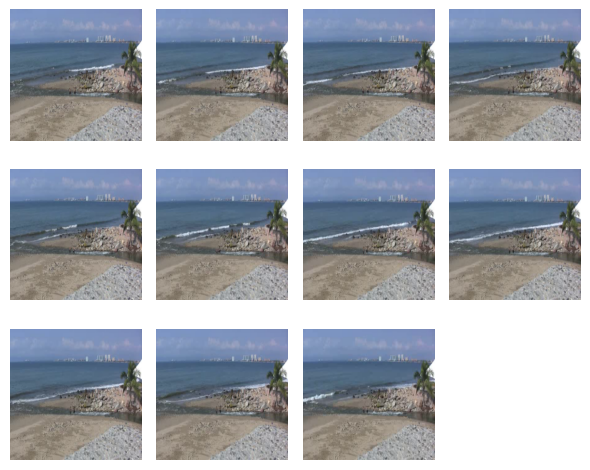

In [ ]:
import matplotlib.pyplot as plt

n = len(example_video)
cols = 4  # Кол-во колонок в гриде
rows = (n + cols - 1) // cols  # Вычисляем нужное кол-во строк

plt.figure(figsize=(6, 5))
for i, img in enumerate(example_video):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
unique_labels = df_train['labels'].unique()
classes = {label: idx for idx, label in enumerate(unique_labels)}
classes

{'water': 0,
 'cloud, water': 1,
 'sunset': 2,
 'car': 3,
 'water, sunset': 4,
 'cloud, sunset': 5,
 'cloud': 6,
 'food': 7,
 'flower, fire': 8,
 'flower': 9,
 'dance': 10,
 'animal': 11,
 'cloud, car': 12,
 'flower, cloud': 13,
 'dance, fire': 14,
 'fire': 15,
 'car, water': 16,
 'dance, car': 17,
 'car, sunset': 18,
 'flower, car': 19}

In [ ]:
class RSNADataset(Dataset):
    # def __init__ - конструктор класс
    def __init__(self, df,  conf, is_test=False):
        self.conf = conf
        self.df = df
        self.transform = A.Compose([
            A.Normalize(),
            # ToTensorV2(p=1.0),
        ],p=1.)

        self.is_test = is_test
        self.samples = []
        # Создаём словарь: класс -> индекс
        self.cls = {'sunset': 0,
                     'cloud': 1,
                     'water': 2,
                     'food': 3,
                     'flower': 4,
                     'car': 5,
                     'cloud, water': 6,
                     'animal': 7,
                     'dance': 8,
                     'fire': 9,
                     'cloud, sunset': 10,
                     'water, sunset': 11,
                     'dance, fire': 12,
                     'car, water': 13,
                     'dance, car': 14,
                     'flower, fire': 15,
                     'car, sunset': 16,
                     'flower, car': 17,
                     'cloud, car': 18,
                     'flower, cloud': 19}

        if is_test:
            for path, label in tzip(df.path, df.labels):
                # read_video(путь, размер, кол-во кадров)
                frames = read_video(self.conf['video_test_path'] + f'/{path}',
                                    self.conf['IMG_SIZE'],
                                    self.conf['MAX_FRAMES'])

                self.samples +=[{'label': self.cls[str(label)],'frames': frames}]
        else:
            for path, label in tzip(df.path, df.labels):
                # read_video(путь, размер, кол-во кадров)
                frames = read_video(self.conf['video_train_path'] + f'/{path}',
                                    self.conf['IMG_SIZE'],
                                    self.conf['MAX_FRAMES'])

                self.samples +=[{'label': self.cls[str(label)],'frames': frames}]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        frames = sample['frames']
        # print(len(frames), frames[0].shape)

        # for i in range(len(frames)):
        #     frames[i] = frames[i] / 255.0

        # if self.transform is not None:
        #     for i in range(len(frames)):
        #         frames[i] = self.transform(image=np.array(frames[i]))['image']

        # torch.from_numpy - перевод в тензоры
        # print(torch.from_numpy(frames, axis=2).shape)
        frames_tr = torch.from_numpy(np.stack(frames, axis=2)).permute(2, 3, 0, 1)
        if self.is_test:
            return frames_tr
        else:
            label = torch.tensor(sample['label']).long()
            return frames_tr, label

In [ ]:
%%time

train_data = RSNADataset(df_train, conf)

train_loader = DataLoader(
        train_data,
        batch_size=conf['TRAIN_BS'],
        shuffle=False
    )

valid_data = RSNADataset(df_valid, conf)

valid_loader = DataLoader(
        valid_data,
        batch_size=conf['VALID_BS'],
        shuffle=False
    )

  0%|          | 0/329 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

CPU times: user 2min 3s, sys: 11.1 s, total: 2min 15s
Wall time: 1min 28s


In [ ]:
for batch in train_loader:
    inputs, labels = batch
    print("Min label:", labels.min().item())
    print("Max label:", labels.max().item())
    break

Min label: 0
Max label: 11


In [ ]:
print(f'Sample len (это эквивалентно количество видео): {len(train_data.samples)}') # всего в датасете 522 видео
print(f'Что лежит в одном видео: {len(train_data.samples[0])}') # в каждом видео лежат два ключа
print(f'Какие ключи: {train_data.samples[0].keys()}')# в каждом видео лежат два ключа
print(f'Что лежит в ключе labels: {train_data.samples[0]["label"]}')# ключ label
print(f'размерность данных по ключу frames: {len(train_data.samples[0]["frames"])}')# лежит 6, так как кадров из видео 6
print(f'Размерность одного кадра, frame: {train_data.samples[0]["frames"][0].shape}') # что лежит в одном кадре, его размерность

Sample len (это эквивалентно количество видео): 329
Что лежит в одном видео: 2
Какие ключи: dict_keys(['label', 'frames'])
Что лежит в ключе labels: 2
размерность данных по ключу frames: 20
Размерность одного кадра, frame: (224, 224, 3)


# Подготовка модели

In [ ]:
## Model Class

class ResNextModel(nn.Module):
    def __init__(self, conf):
        super(ResNextModel, self).__init__()
        self.conf = conf
        self.backbone = timm.create_model(self.conf['FEATURE_EXTRACTOR'],
                                          pretrained=True)

    def forward(self, x):
        return self.backbone(x)


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class RSNAModel(nn.Module):
    def __init__(self, conf, pretrained=True):
        super(RSNAModel, self).__init__()
        self.conf = conf
        self.backbone = ResNextModel(self.conf)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.num_features = self.backbone.backbone.fc.in_features

        self.backbone.backbone.fc = Identity()
        self.dropout = nn.Dropout(self.conf['DR_RATE'])
        self.rnn = nn.LSTM(self.num_features, self.conf['RNN_HIDDEN_SIZE'],
                           self.conf['RNN_LAYERS'], dropout=0.1,
                           batch_first=True, bidirectional=True)  # bidirectional=True
        self.fc1 = nn.Linear(self.conf['RNN_HIDDEN_SIZE'] * 2, self.conf['NUM_CLASSES']) #выходной слой

    def forward(self, x):
        b, f, c, h, w = x.shape
        # print(x.reshape(b * f, c, h, w).shape)
        x = self.backbone(x.reshape(b * f, c, h, w))
        # print(x.shape)
        x = x.reshape(b, f, self.num_features)
        # print(x.shape)
        x, _ = self.rnn(x)
        # print(x.shape)
        x = self.dropout(x[:, -1])  #
        # print(x.shape, self.num_features)
        x = self.fc1(x)
        return x

In [ ]:
def train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch, device, verbose=False):
    """
    Trains model for one epoch
    """
    model.train()
    running_loss = 0
    # for i in tqdm([]))
    prog_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for batch, (frames, targets) in prog_bar:
        optimizer.zero_grad()

        frames = frames.to(device, torch.float)
        targets = targets.to(device)

        # # Re arrange the frames in the format our model wants to recieve
        preds = model(frames)
        loss = loss_fn(preds, targets)

        loss.backward()
        optimizer.step()

        loss_item = loss.item()
        running_loss += loss_item

        prog_bar.set_description(f"loss: {loss_item:.4f}")

        if verbose == True and batch % 20 == 0:
            print(f"Batch: {batch}, Loss: {loss_item}")

    avg_loss = running_loss / len(train_dataloader)

    return avg_loss

@torch.no_grad()
# def train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch, device, log_wandb=True, verbose=False):
def valid_one_epoch(model, valid_dataloader, loss_fn, epoch, device, verbose=False):
    """
    Validates the model for one epoch
    """
    model.eval()
    running_loss = 0
    prog_bar = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader))
    for batch, (frames, targets) in prog_bar:
        frames = frames.to(device, torch.float)
        targets = targets.to(device)

        # Re arrange the frames in the format our model wants to recieve
        preds = model(frames)
        loss = loss_fn(preds, targets)

        loss_item = loss.item()
        running_loss += loss_item

        prog_bar.set_description(f"val_loss: {loss_item:.4f}")


        if verbose == True and batch % 10 == 0:
            print(f"Batch: {batch}, Loss: {loss_item}")

    avg_val_loss = running_loss / len(valid_dataloader)

    return avg_val_loss

In [ ]:
# Функция main, которая собирает все вместе
# она принимает разные конфигурации для выполнения всех программ
# лоадер данных - df_loader
# df - это датафрейм (где путь, класс)
# output_path - путь куда сохранить ответы
# device - GPU/CPU - на чем делать вычисления
def main(conf, train_loader, valid_loader,  output_path, device):

    # создаем модель
    model = RSNAModel(conf)
    # передаем модели на чем делать вычисления GPU/CPU
    model = model.to(device)

    # Тут начинается обучение модели
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=conf['LR'])
    # SGD

    train_loss_fn = nn.CrossEntropyLoss()
    valid_loss_fn = nn.CrossEntropyLoss()

    # train_loss_fn = nn.BCEWithLogitsLoss()
    # valid_loss_fn = nn.BCEWithLogitsLoss()

    print(f"\nUsing Backbone: {conf['FEATURE_EXTRACTOR']}")
    conf['EPOCHS'] = 10
    current_loss = 1000
    for epoch in range(conf['EPOCHS']):
        print(f"\n{'--'*8} EPOCH: {epoch+1} {'--'*8}\n")

        train_loss = train_one_epoch(model,
                                     train_loader,
                                     optimizer,
                                     train_loss_fn,
                                     epoch=epoch, device=device)

        valid_loss = valid_one_epoch(model,
                                     valid_loader,
                                     valid_loss_fn,
                                     epoch=epoch, device=device)

        print(f"val_loss: {valid_loss:.4f}")

        if valid_loss < current_loss:
            current_loss = valid_loss
            torch.save(model.state_dict(), f"model_{conf['FEATURE_EXTRACTOR']}.pt")

    # тут происходит предсказание ответа
    gt = []
    pred = [] # массив куда будем сохранять ответы
    model.eval()

    # prog_bar - это просто чтобы красиво выводился процесс вычисления
    # в виде бегущей крассивой штукой и показом процента выполнения
    gt = []
    pred = []
    model.eval()
    prog_bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    for batch, (frames, targets) in prog_bar:
        frames = frames.to('cuda').float()
        gt +=  list(targets.numpy())
        with torch.no_grad():

            pred += list(model(frames).argmax(dim=-1).to('cpu').flatten().numpy())

    torch.save(model.state_dict(),'sample_model.pt')

    # сохраняем ответы в датафрейм с путями в новую колонку labels_pred
    df_valid['labels_pred'] = pred

    # сохраняем ответы в файл csv
    os.makedirs(output_path, exist_ok=True)
    df_valid['labels_pred'].to_csv(output_path + 'predictions.csv')

In [ ]:
%%time

# ВСЕ ЗАПУСКАЕМ

if torch.cuda.is_available():
    print("Using GPU: {}\n".format(torch.cuda.get_device_name()))
    device = torch.device('cuda')
else:
    print("\nGPU not found. Using CPU: {}\n".format(platform.processor()))
    device = torch.device('cpu')

main(conf, train_loader, valid_loader, 'output/', device)

Using GPU: Tesla T4


Using Backbone: resnext101_64x4d

---------------- EPOCH: 1 ----------------



loss: 2.7306:  27%|██▋       | 9/33 [00:23<01:04,  2.68s/it]

In [ ]:
unique_labels = df_train['labels'].unique()
classes = {label: idx for idx, label in enumerate(unique_labels)}
df_valid['labels_idx'] = df_valid['labels'].map(classes)

df_valid.head()

,path,labels,labels_pred,labels_idx
0,000984125-marina-kona-coast-hawaii_preview.mp4,flower,1,3
1,_import_614efb3229e902.59139691_preview.mp4,sunset,2,2
2,160825_05_Sunflowers3_1080p_preview.mp4,flower,3,3
3,210603_02_July 4_4k_003_preview.mp4,food,5,5
4,port_before_sunrise_preview.mp4,sunset,1,2


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print(accuracy_score(df_valid['labels_idx'].values, df_valid['labels_pred'].values))
print(f1_score(df_valid['labels_idx'].values, df_valid['labels_pred'].values, average='weighted'))

0.603448275862069
0.5807710545033061


<Axes: >

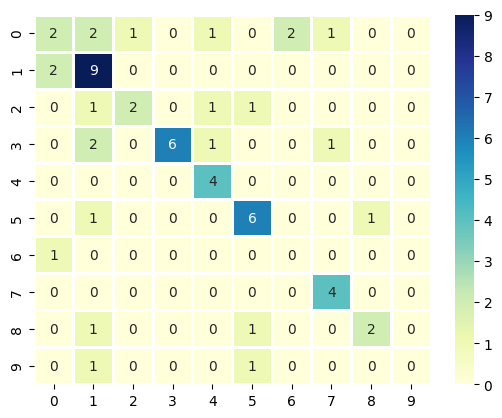

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(df_valid['labels_idx'].values, df_valid['labels_pred'].values)

sns.heatmap(conf_matrix, annot = True, cmap="YlGnBu", linecolor='white', linewidths=1)

# Подготовка ответов для test

In [ ]:
sample_submit.columns = ['index', 'path', 'labels']
sample_submit['labels'] = 'animal'
sample_submit

,index,path,labels
0,0,Arizona sunset with creosote bush_preview.mp4,animal
1,1,_import_616e7f78a17260.13545125_preview.mp4,animal
2,2,200506_Kitchen Food_04_4k_032_preview.mp4,animal
3,3,Pordeitev_smrek_preview.mp4,animal
4,4,City street time lapse-H264 75_preview.mp4,animal
...,...,...,...
430,430,Sydney_storm_preview.mp4,animal
431,431,Alaska spring shrub in wind_preview.mp4,animal
432,432,190111_16_MuayThaiTraining_HD_04_preview.mp4,animal
433,433,Ireland Dingle Peninsula road above sea cliffs...,animal


In [ ]:
test_data = RSNADataset(sample_submit, conf, is_test=True)

test_loader = DataLoader(
        test_data,
        batch_size=7,
        shuffle=False
    )

  0%|          | 0/435 [00:00<?, ?it/s]

In [ ]:
for frames in test_loader:
    print(frames.shape)
    break

torch.Size([7, 11, 3, 224, 224])


In [ ]:
model = RSNAModel(conf)
# передаем модели на чем делать вычисления GPU/CPU
model.load_state_dict(torch.load('sample_model.pt', weights_only=True))
model = model.to(device)

In [ ]:
# тут происходит предсказание ответа
gt = []
pred = [] # массив куда будем сохранять ответы
model.eval()

# prog_bar - это просто чтобы красиво выводился процесс вычисления
# в виде бегущей крассивой штукой и показом процента выполнения
gt = []
pred = []
model.eval()
prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))

for batch, frames in prog_bar:
    frames = frames.to('cuda').float()
    with torch.no_grad():
        pred += list(model(frames).argmax(dim=-1).to('cpu').flatten().numpy())

# сохраняем ответы в датафрейм с путями в новую колонку labels_pred
sample_submit['labels_pred'] = pred

100%|██████████| 63/63 [00:59<00:00,  1.07it/s]


In [ ]:
my_submit = pd.read_csv('/kaggle/input/what-on-the-video/sample_submit.csv')
my_submit

,index,file_name,label
0,0,Arizona sunset with creosote bush_preview.mp4,"sunset, cloud"
1,1,_import_616e7f78a17260.13545125_preview.mp4,"sunset, cloud"
2,2,200506_Kitchen Food_04_4k_032_preview.mp4,"sunset, cloud"
3,3,Pordeitev_smrek_preview.mp4,"sunset, cloud"
4,4,City street time lapse-H264 75_preview.mp4,"sunset, cloud"
...,...,...,...
430,430,Sydney_storm_preview.mp4,animal
431,431,Alaska spring shrub in wind_preview.mp4,animal
432,432,190111_16_MuayThaiTraining_HD_04_preview.mp4,animal
433,433,Ireland Dingle Peninsula road above sea cliffs...,animal


In [ ]:
my_submit.columns = ['index', 'file_name', 'label']
my_submit['label'] = sample_submit['labels_pred']

my_submit['label'] = my_submit['label'].map(id2label)
my_submit[['index','file_name', 'label']].to_csv('my_baseline_submit.csv', index=False)